# CHEM452 - The basics of the RDkit package for molecular featurization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pandas as pd
!pip install rdkit-pypi
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 1.3 MB/s 


#RDKit Features (2D & 3D)

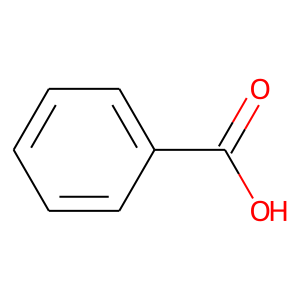

In [ ]:
m = Chem.MolFromSmiles('c1ccccc1C(=O)O') #Benzoic acid
Draw.MolToImage(m)

Here are a few 2D properties RDKit can generate:

In [ ]:
from rdkit.Chem import Descriptors
from rdkit.Chem import Descriptors3D
print('MolecularWeight = {}'.format(Descriptors.MolWt(m)))
print('MolLogP = {}'.format(Descriptors.MolLogP(m)))
print('AromaticRings = {}'.format(Descriptors.NumAromaticRings(m)))
print('HeavyAtoms = {}'.format(Descriptors.HeavyAtomCount(m)))
print('TopologicalPolarSurfaceArea = {} A^2'.format(Descriptors.TPSA(m)))
print('NumHDonors = {}'.format(Descriptors.NumHDonors(m)))

AllChem.ComputeGasteigerCharges(m)
print('PartialChargeOnAtom0 = {}'.format(m.GetAtomWithIdx(0).GetDoubleProp('_GasteigerCharge')))

MolecularWeight = 122.12299999999998
MolLogP = 1.3848
AromaticRings = 1
HeavyAtoms = 9
TopologicalPolarSurfaceArea = 37.3 A^2
NumHDonors = 1
PartialChargeOnAtom0 = -0.04769375004654255


Here are some 3D Properties from RDKit. 3D geometries must be infered or calculated by RDKit.

In [ ]:
# 3D Properties Require adding hydrogens and Embedding the molecule to make it 3D
m2=Chem.AddHs(m)
AllChem.EmbedMolecule(m2)
print('RadiusOfGyration = {}'.format(Descriptors3D.RadiusOfGyration(m2)))
print('Asphericity = {}'.format(Descriptors3D.Asphericity(m2)))

# You can also minimize a 3D structure to get slightly better accuracy
AllChem.MMFFOptimizeMolecule(m2)
print('MMFF_RadiusOfGyration = {}'.format(Descriptors3D.RadiusOfGyration(m2)))
print('MMFF_Asphericity = {}'.format(Descriptors3D.Asphericity(m2)))

RadiusOfGyration = 2.1150009227110256
Asphericity = 0.46362494385120745
MMFF_RadiusOfGyration = 2.111208193172457
MMFF_Asphericity = 0.45518149893813264


# Morgan Fingerprint

This generates fingerprints, prints the IDs of all fingerprints and how often they appear, and then prints one specific fingerprint.

In [ ]:
#m = Chem.MolFromSmiles('c1cccnc1C')
bi={}
fp = AllChem.GetMorganFingerprint(m,radius=2,bitInfo=bi)
print(fp.GetNonzeroElements())

{98513984: 3, 128522177: 2, 864662311: 1, 864942730: 1, 951226070: 2, 1466409066: 1, 1510328189: 1, 1533864325: 1, 1710869618: 1, 2246699815: 1, 2763854213: 1, 2784506312: 1, 2994748777: 1, 3217380708: 1, 3218693969: 5, 3999906991: 2}


In [ ]:
## This Draws the fingerprint
!pip install ipyplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.3 MB/s 


In [ ]:
import ipyplot
print(bi[98513984]) #tuples are (atom,radius) that the fingerprint occured
svgfile = Draw.DrawMorganBit(m, 98513984, bi, useSVG=True)
ipyplot.plot_images(
    [svgfile], # images should be passed in as an array
    img_width=250)

((1, 1), (2, 1), (3, 1))


# Batch of Fingerprints

In [ ]:
Tm_df = pd.read_csv("Tm_200_subset_original.csv")
Tm_df.head()

,smiles,Tm,num_atms,dipole,quadrupole
0,CC1=C(C=CC(O)=N1)[N+]([O-])=O,508.15,17,4.473978,23.191697
1,COC1=C(N)C=C(C=C1)C(=O)N(C)C,393.15,28,4.772571,21.767880
2,CC1=CC=C(Cl)C(N)=C1,303.95,17,2.216088,7.920099
3,BrC1(C(=O)C2=CC=CC=C2C1=O)C1=CC=CC=C1,379.15,27,3.919235,21.700726
4,NC1=C(Cl)C=C(Cl)C=C1I,353.15,14,2.157331,4.988358


Check data types and for missing values. Convert SMILES to string.

In [ ]:
Tm_df.smiles = Tm_df.smiles.astype('string')
Tm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   smiles      201 non-null    string 
 1   Tm          201 non-null    float64
 2   num_atms    201 non-null    int64  
 3   dipole      201 non-null    float64
 4   quadrupole  201 non-null    float64
dtypes: float64(3), int64(1), string(1)
memory usage: 8.0 KB


Create a list of molecules.

In [ ]:
mols = [Chem.MolFromSmiles(smiles) for smiles in Tm_df['smiles']]
#print(Tm_df.to_string())

Use RdKit to obtain molecular fingerprints for the entire dataset.

In [ ]:
from rdkit import DataStructs
radius = 3
nBits = 1024
info = {}
fps = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, bitInfo=info) for mol in mols]
fps_np_array = []
for fp_object in fps:
  fp_vect = np.zeros((1,), dtype=float)
  DataStructs.ConvertToNumpyArray(fp_object, fp_vect)
  fps_np_array.append(fp_vect)
  print(fp_vect)

There are 36 fingerprints
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 